# North Atlantic O2 gapfill
    - Absolute magnitude of O2 is estimated as a function of T, S, long, lat, and time (year, month)
    - Reads in the data from WOD profiles
    - Separates the data into training and test data (75% - 25%)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import sklearn as skl
import gsw
import cartopy.crs as ccrs
from scipy.interpolate import interp1d
import os
import warnings
warnings.filterwarnings('ignore')

### First prepare O2, T, S, stratification data

In [2]:
# observational data 
# -------------------------------------------------------------
# Needs adjustment: this is where you write out the output files
diro = '/glade/scratch/ito/WOD18_OSDCTD/'
# -------------------------------------------------------------
dirf = '/glade/campaign/univ/ugit0034/EN4/L09_20x180x360/'
fosd='_1x1bin_osd_'
fctd='_1x1bin_ctd_'
fmer='_1x1bin_merged_'
var=['o2','TSN2']
os.system('mkdir -p '+diro)
os.system('mkdir -p '+diro+'temp')

0

In [3]:
dwoa=xr.open_dataset('/glade/campaign/univ/ugit0034/woa18/woa18_all_o00_01.nc',decode_times=False)

In [4]:
# basin mask
dsm=xr.open_dataset('/glade/campaign/univ/ugit0034/wod18/basin_mask_01.nc')
#! cp /glade/work/ito/basin_mask_01.nc /glade/campaign/univ/ugit0034/wod18/.

In [5]:
# select depth level
zlev=100
#
# select analysis period
#  do not change the start year from 1965 (this is when Carpenter 1965 established modern Winkler method)
yrs=np.arange(1965,2019,1)
# 

In [6]:
#
# Obtain TS data from observational gridded dataset
#
Nt=np.size(yrs)*12
mon=["%.2d" % i for i in np.arange(1,13,1)]
#
o2=np.zeros((Nt,180,360))
t=np.zeros((Nt,180,360))
s=np.zeros((Nt,180,360))
#
for year in yrs:
    #print(str(year))
    ds=xr.open_dataset(diro+var[0]+fmer+str(year)+'.nc')
    tr=12*(year-1965)
    o2[tr:(tr+12),:,:]=ds.o2.sel(depth=zlev).to_numpy()
    #
    #option 2. use EN4 for training#
    for mn in range(12):
        ds = xr.open_dataset(dirf+'EN4_TSN2_L09_180x360_'+str(year)+mon[mn]+'.nc')
        s[tr+mn,:,:]=ds.SA.interp(depth=zlev).to_numpy().squeeze()
        t[tr+mn,:,:]=ds.CT.interp(depth=zlev).to_numpy().squeeze()

In [7]:
# get coordinates
x=ds.lon.to_numpy()
y=ds.lat.to_numpy()
xi=np.arange(0,360,1)
yi=np.arange(0,180,1)
xx,yy=np.meshgrid(x,y)
xxi,yyi=np.meshgrid(xi,yi)

In [8]:
# extract mask in the Atlantic basin at 500m depth
mask= dsm.basin_mask.sel(depth=zlev)

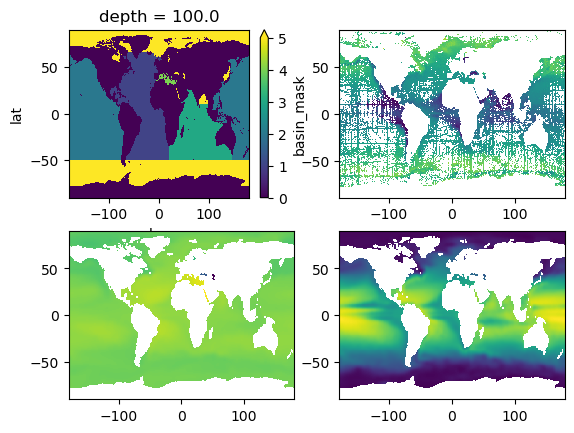

In [9]:
# take a look at the data
fig,ax=plt.subplots(2,2)
mask.plot(ax=ax[0,0],vmin=0,vmax=5,label='basin_mask')
ax[0,1].pcolormesh(x,y,np.nanmean(o2,axis=0))
ax[1,0].pcolormesh(x,y,np.nanmean(s,axis=0))
ax[1,1].pcolormesh(x,y,np.nanmean(t,axis=0))

In [10]:
# select Atlantic basin
# Atlantic is mask = 1
ma = dsm.basin_mask.sel(depth=zlev).to_numpy()

In [11]:
# make numpy array
doa = o2
dsa = s
dta = t
#
# prepare lat lon time data
xx1 = np.tile(xx,[Nt,1,1])
yy1 = np.tile(yy,[Nt,1,1])
t0=np.arange(0,Nt,1)
t1=t0%12
t2=np.sin(t0*np.pi/6)
tt0 = np.tile(t0,[180,360,1])
tt1 = np.transpose(tt0,(2,0,1))
tc0 = np.tile(t1,[180,360,1])
tc1 = np.transpose(tc0,(2,0,1))
ts0 = np.tile(t2,[180,360,1])
ts1 = np.transpose(ts0,(2,0,1))

In [12]:
# apply mask for the north atlantic
doa=np.where((ma==1)&(yy>0),doa,np.nan)
dsa=np.where((ma==1)&(yy>0),dsa,np.nan)
dta=np.where((ma==1)&(yy>0),dta,np.nan)

### Now we have the data for the North Atlantic. Remove NaNs and organize them into 1d array

In [13]:
# create data vector
doa0 = doa.flatten()
dsa0 = dsa.flatten()
dta0 = dta.flatten()
xx0  = xx1.flatten()
yy0  = yy1.flatten()
tt0  = tt1.flatten()
tc0  = tc1.flatten()
ts0  = ts1.flatten()

In [14]:
# remove nan
dd = doa0 + dsa0 + dta0# + dra0 + dha0# + dga0
doa1=doa0[np.isnan(dd)==False]
dsa1=dsa0[np.isnan(dd)==False]
dta1=dta0[np.isnan(dd)==False]
xx1=xx0[np.isnan(dd)==False]
yy1=yy0[np.isnan(dd)==False]
tt1=tt0[np.isnan(dd)==False]
tc1=tc0[np.isnan(dd)==False]
ts1=ts0[np.isnan(dd)==False]
Nsample = np.size(doa1)
print(Nsample)

30886


### This is where we choose what variables to include

In [15]:
# generate data matrix and standardize it
X = np.array([dsa1, dta1, xx1, yy1, tt1, tc1])
y = doa1
#
Xm = np.mean(X,axis=1)
Xstd = np.std(X,axis=1)
#
N=np.size(y)
# normalize x and y
Xa = (X.T - Xm)/Xstd
ym = np.mean(y)
ystd = np.std(y)
ya = (y-ym)/ystd

## ML

### First split the data into training and test set

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xa, ya,random_state=1)

### MLR estimator (MLregr)

In [17]:
##
## Multiple Linear Regression
##
from sklearn.linear_model import LinearRegression

In [18]:
# fit model
MLregr = LinearRegression().fit(X_train, y_train)
#MLregr.coef_
#MLregr.intercept_
out=MLregr.predict(X_test)

In [19]:
# test model output
score=MLregr.score(X_test, y_test)
print(score)
MLregr.get_params()

0.7077164526139597


{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

correlation =  0.8413767842126963
RMSE =  30.28545039868114


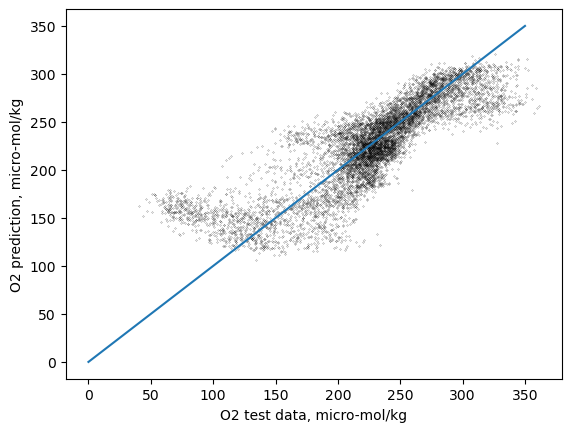

In [20]:
o2est = out*ystd + ym
o2test= y_test*ystd + ym
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([0,350],[0,350])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_MLR=temp[0,1]
print('correlation = ',Rval_MLR)
RMSE_MLR=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE_MLR)

### Random Forest Regressor (RFregr)

In [21]:
##
## RF
##
from sklearn.ensemble import RandomForestRegressor

In [22]:
#RFregr = RandomForestRegressor(n_estimators=500,min_samples_leaf=12,max_features=3)
RFregr = RandomForestRegressor()
RFregr.fit(X_train, y_train)

RandomForestRegressor()

In [23]:
out = RFregr.predict(X_test)
RFregr.score(X_test, y_test)
#RFregr.get_params()

0.938183309126832

R2 =  0.9381836982463172
RMSE =  13.927870768138618


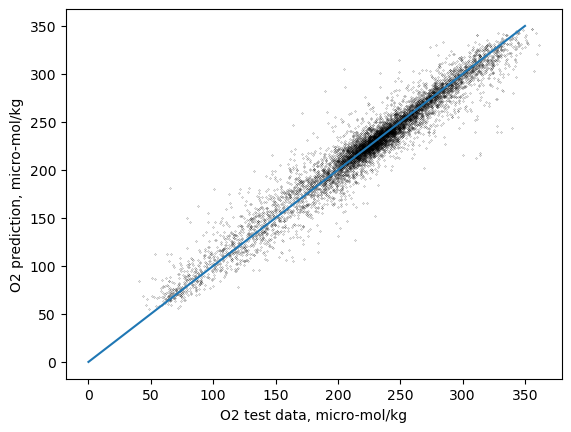

In [24]:
o2est = out*ystd + ym
o2test= y_test*ystd + ym
#
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([0,350],[0,350])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_RF=temp[0,1]
print('R2 = ',Rval_RF**2)
RMSE_RF=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE_RF)

### Neural Network estimator (NNregr)

In [25]:
## NN
from sklearn.neural_network import MLPRegressor

In [26]:
NNregr = MLPRegressor(hidden_layer_sizes=(10,10,10,10),alpha=0.01, 
                      random_state=1, max_iter=1000).fit(X_train, y_train)

In [27]:
out = NNregr.predict(X_test)
NNregr.score(X_test, y_test)

0.9265794064956845

correlation =  0.9627162338047867
RMSE =  15.178917390760347


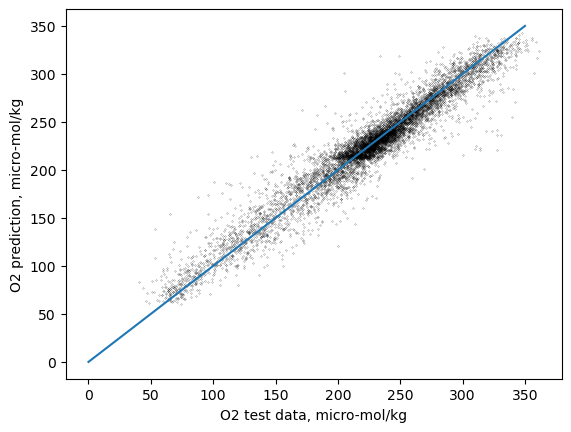

In [28]:
o2est = out*ystd + ym
o2test= y_test*ystd + ym
#
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([0,350],[0,350])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_NN=temp[0,1]
print('correlation = ',Rval_NN)
RMSE_NN=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE_NN)

## reconstruction: mapping O2 for all year and month

In [29]:
mon=["%.2d" % i for i in np.arange(1,13,1)]
yrs=np.arange(1965,2019,1)
t=np.arange('1965-01','2019-01',dtype='datetime64[M]')
dc=xr.open_dataset(dirf+'EN4_TSN2_L09_180x360_'+str(1965)+mon[0]+'.nc')
y=dc.lat.to_numpy()
x=dc.lon.to_numpy()
Ny=np.size(y)
Nx=np.size(x)
Nt=np.size(yrs)*12
xx,yy=np.meshgrid(x,y)

In [30]:
# apply basin mask 
def apply_basinmask(datain):
    dataout=np.where((ma==1)&(yy>0),datain,np.nan)
    return dataout

In [31]:
def moving_average(data,w):
    weight=np.ones(w)/w
    smooth_data=np.convolve(data, weight, mode='same')
    return smooth_data

In [32]:
# get input data from full model
def get_inputdata(zlev,it,year,mn):
    #dc = xr.open_dataset(dirf+'EN4_TSN2_G10_180x360_'+str(year)+mon[mn]+'.nc')
    dc = xr.open_dataset(dirf+'EN4_TSN2_L09_180x360_'+str(year)+mon[mn]+'.nc')
    soa=dc.SA.interp(depth=zlev).to_numpy().squeeze()
    toa=dc.CT.interp(depth=zlev).to_numpy().squeeze()
    return soa,toa

In [33]:
# generate data matrix
def gen_datamatrix(xi,yi,it,x1,x2,x3,x4):
    X1 = x1.flatten() # 
    X2 = x2.flatten() # 
    X3 = x3.flatten() # 
    X4 = x4.flatten() # 
    tt0  = np.ones((Ny,Nx))*it
    X5 = tt0.flatten() # decimal year 
    X6 = X5%12         # month
    xxi = xi.flatten() # lon
    yyi = yi.flatten() # lat
    # remove nan
    dd = X1+X2+X3+X4+X5
    X11=X1[np.isnan(dd)==False]
    X21=X2[np.isnan(dd)==False]
    X31=X3[np.isnan(dd)==False]
    X41=X4[np.isnan(dd)==False]
    X51=X5[np.isnan(dd)==False]
    X61=X6[np.isnan(dd)==False]
    #
    Xi=xxi[np.isnan(dd)==False]
    Yi=yyi[np.isnan(dd)==False]
    # Normalize data
    # generate data matrix and standardize it
    X = np.array([X11, X21, X31, X41, X51, X61])
    Xa = (X.T - Xm)/Xstd
    Nsample = np.size(X11)
    #print(Nsample)
    return Xa,Xi,Yi

In [34]:
def map_yearly(year):
    Nx=np.size(x)
    Ny=np.size(y)
    o2est2=np.zeros((12,Ny,Nx))
    xxi,yyi=np.meshgrid(np.arange(0,Nx,1),np.arange(0,Ny,1))
    if year%10 == 5:
        print('year = '+str(year))
    t=np.arange(str(year)+'-01',str(year+1)+'-01',dtype='datetime64[M]')
    for month in range(12):
        it = month+(year-1965)*12
        soa,toa = get_inputdata(zlev,it,year,month)
        # apply mask
        soa=apply_basinmask(soa)
        toa=apply_basinmask(toa)
        # generate data matrix
        Xa,xi,yi=gen_datamatrix(xxi,yyi,it,soa,toa,xx,yy)
        temp = np.shape(Xa)
        Nsample=temp[0]
        # projection
        out = reg.predict(Xa)
        # map it back to lon-lat grid
        temp = np.nan*np.zeros((Ny,Nx))
        for n in range(Nsample):
            temp[yi[n],xi[n]]=out[n]
        o2est2[month,:,:] = temp*ystd + ym
    da1=xr.DataArray(data=o2est2,name='o2est',dims=['time','lat','lon'],
                 coords={'time':t,'lat':y,'lon':x})
    ds=da1.to_dataset()
    ds.to_netcdf(diro+'temp/o2est_'+str(year)+'.nc')
    return 0

In [35]:
#
# reconstruction using NN
#
yrs=np.arange(1965,2019,1)
#yrs=[1965,1966]
reg=NNregr
x=dc.lon
y=dc.lat
#
from multiprocessing import Pool
if __name__ == '__main__':
    with Pool(10) as p:
        print(p.map(map_yearly, yrs))

year = 1965year = 1975

year = 1985
year = 1995
year = 2005
year = 2015
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [36]:
#
# save the result as a netCDF file
#
dtemp=xr.open_mfdataset(diro+'temp/o2est*.nc')
dtemp.to_netcdf(diro+'/O2abs_NA'+str(zlev)+'m_NN_WOD18O2xEN4TS_monthly_v1.nc')

In [37]:
#
# reconstruction using MLR
#
yrs=np.arange(1965,2019,1)
#yrs=[1965,1966]
reg=MLregr
x=dc.lon
y=dc.lat
#
os.system('rm '+diro+'/temp/*.nc')
#
from multiprocessing import Pool
if __name__ == '__main__':
    with Pool(10) as p:
        print(p.map(map_yearly, yrs))

year = 1975year = 1965

year = 1985
year = 1995
year = 2005
year = 2015
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [38]:
dtemp=xr.open_mfdataset(diro+'temp/o2est*.nc')
dtemp.to_netcdf(diro+'/O2abs_NA'+str(zlev)+'m_MLR_WOD18O2xEN4TS_monthly_v1.nc')

In [39]:
yrs=np.arange(1965,2019,1)
#yrs=[1965,1966]
reg=RFregr
x=dc.lon
y=dc.lat
#
os.system('rm '+diro+'/temp/*.nc')
#
from multiprocessing import Pool
if __name__ == '__main__':
    with Pool(10) as p:
        print(p.map(map_yearly, yrs))

year = 1975year = 1965

year = 1985
year = 1995
year = 2005
year = 2015
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [40]:
dtemp=xr.open_mfdataset(diro+'temp/o2est*.nc')
dtemp.to_netcdf(diro+'/O2abs_NA'+str(zlev)+'m_RF_WOD18O2xEN4TS_monthly_v1.nc')

In [41]:
# generate plots for analysis

In [42]:
ds0 = xr.open_dataset(diro+'/O2abs_NA'+str(zlev)+'m_MLR_WOD18O2xEN4TS_monthly_v1.nc')
o2clim0 = ds0.o2est.groupby('time.month').mean('time')
ds1 = xr.open_dataset(diro+'/O2abs_NA'+str(zlev)+'m_NN_WOD18O2xEN4TS_monthly_v1.nc')
o2clim1 = ds1.o2est.groupby('time.month').mean('time')
ds2 = xr.open_dataset(diro+'/O2abs_NA'+str(zlev)+'m_RF_WOD18O2xEN4TS_monthly_v1.nc')
o2clim2 = ds2.o2est.groupby('time.month').mean('time')

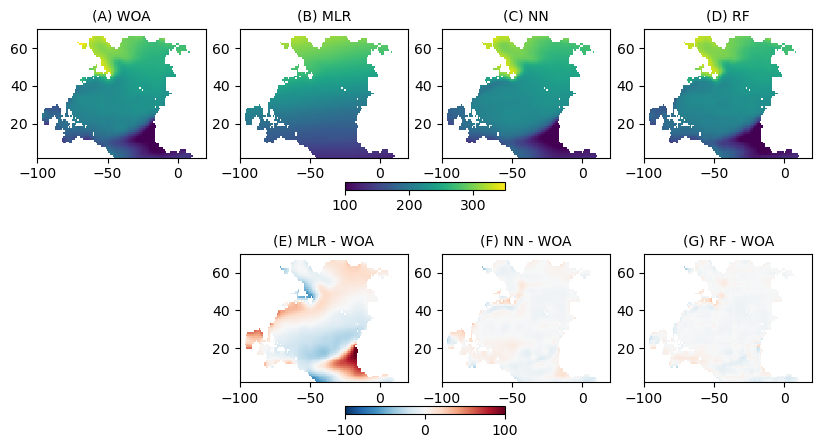

In [43]:
#
# Evaluate annual mean climatology\
#
fig=plt.figure(figsize=(10,5))
ax=fig.subplots(2,4)
lon=ds0.lon
lat=ds0.lat
o2woa=dwoa.o_an.sel(depth=zlev,method='nearest').mean('time').to_numpy()
o2woa=np.where(np.isnan(o2clim0[0,:,:]),np.nan,o2woa)
ax=ax.flatten()
fig.subplots_adjust(hspace=0.4)
#
im=ax[0].pcolormesh(lon,lat,o2woa,vmin=100,vmax=350)
ax[0].set_xlim(-100,20)
ax[0].set_ylim(2,70)
ax[0].set_title('(A) WOA',fontsize=10)
#
ax[1].pcolormesh(lon,lat,np.mean(o2clim0,axis=0),vmin=100,vmax=350)
ax[1].set_xlim(-100,20)
ax[1].set_ylim(2,70)
ax[1].set_title('(B) MLR',fontsize=10)
#
ax[2].pcolormesh(lon,lat,np.mean(o2clim1,axis=0),vmin=100,vmax=350)
ax[2].set_xlim(-100,20)
ax[2].set_ylim(2,70)
ax[2].set_title('(C) NN',fontsize=10)
#
ax[3].pcolormesh(lon,lat,np.mean(o2clim2,axis=0),vmin=100,vmax=350)
ax[3].set_xlim(-100,20)
ax[3].set_ylim(2,70)
ax[3].set_title('(D) RF',fontsize=10)
#
fig.colorbar(im, ax=ax[:4], location='bottom',fraction=.05)
#
im=ax[5].pcolormesh(lon,lat,np.mean(o2clim0,axis=0)-o2woa,vmin=-100,vmax=100,cmap='RdBu_r')
ax[5].set_xlim(-100,20)
ax[5].set_ylim(2,70)
ax[5].set_title('(E) MLR - WOA',fontsize=10)
#
ax[6].pcolormesh(lon,lat,np.mean(o2clim1,axis=0)-o2woa,vmin=-100,vmax=100,cmap='RdBu_r')
ax[6].set_xlim(-100,20)
ax[6].set_ylim(2,70)
ax[6].set_title('(F) NN - WOA',fontsize=10)
#
ax[7].pcolormesh(lon,lat,np.mean(o2clim2,axis=0)-o2woa,vmin=-100,vmax=100,cmap='RdBu_r')
ax[7].set_xlim(-100,20)
ax[7].set_ylim(2,70)
ax[7].set_title('(G) RF - WOA',fontsize=10)
#
fig.colorbar(im, ax=ax[4:8], location='bottom',fraction=.05)
#
ax[4].remove()

In [44]:
#
# CALCULATE RMSE
#
rmse=np.empty(3)
#
tmp=np.mean(o2clim0,axis=0).to_numpy()-o2woa
rmse[0]=np.nanmean(tmp.flatten()**2)
tmp=np.mean(o2clim1,axis=0).to_numpy()-o2woa
rmse[1]=np.nanmean(tmp.flatten()**2)
tmp=np.mean(o2clim2,axis=0).to_numpy()-o2woa
rmse[2]=np.nanmean(tmp.flatten()**2)
rmse=np.sqrt(rmse)
print(f'RMSE = {rmse}')
#

RMSE = [23.79030117  5.34682969  4.41873129]


In [45]:
# Next evaluate Monthly climatology for NN and RF
dwoa=xr.open_mfdataset('/glade/campaign/univ/ugit0034/woa18/monthly/woa18_all_o*_01.nc',decode_times=False)

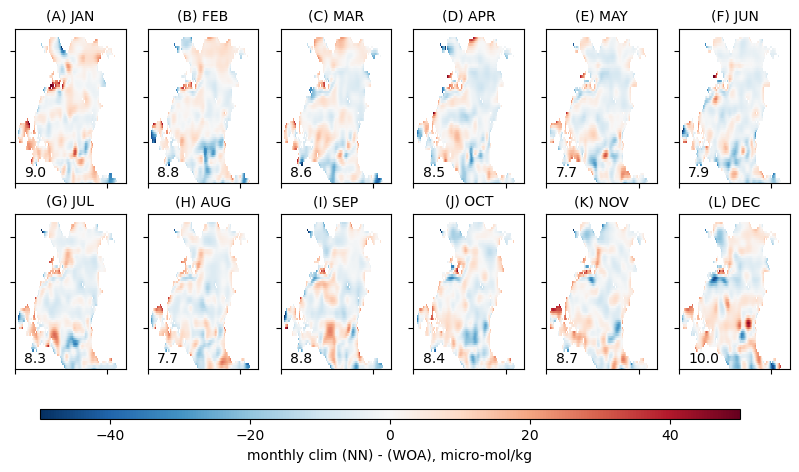

In [46]:
fig=plt.figure(figsize=(10,5))
ax=fig.subplots(2,6)
lon=dwoa.lon
lat=dwoa.lat
o2woa=dwoa.o_an.sel(depth=zlev,method='nearest').to_numpy()
ax=ax.flatten()
fig.subplots_adjust(bottom=0.2)
rmse_mon=np.empty(12)
mtit=['(A) JAN','(B) FEB','(C) MAR','(D) APR','(E) MAY','(F) JUN','(G) JUL','(H) AUG','(I) SEP','(J) OCT','(K) NOV','(L) DEC']
#
for m in range(12):
    data=np.where(ma==1,o2clim1[m,:,:] - o2woa[m,:,:],np.nan)
    im=ax[m].pcolormesh(lon,lat,data,vmin=-50,vmax=50,cmap='RdBu_r')
    ax[m].set_xlim(-100,20)
    ax[m].set_ylim(2,70)
    ax[m].set_yticklabels('')
    ax[m].set_xticklabels('')
    rmse_mon[m]=np.sqrt(np.nanmean(data.flatten()**2))
    ax[m].text(-90,5,str(np.round(rmse_mon[m],1)))
    ax[m].set_title(mtit[m],fontsize=10)
#
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
cbar=fig.colorbar(im,orientation='horizontal',cax=cbar_ax)
cbar.set_label('monthly clim (NN) - (WOA), micro-mol/kg')

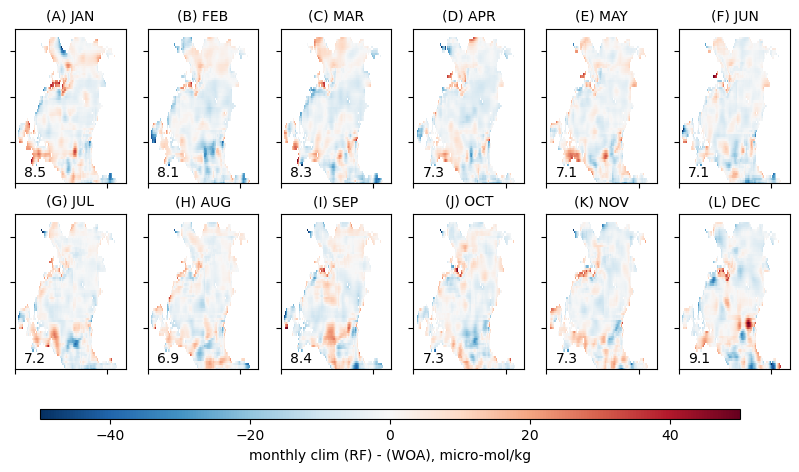

In [47]:
fig=plt.figure(figsize=(10,5))
ax=fig.subplots(2,6)
ax=ax.flatten()
fig.subplots_adjust(bottom=0.2)
rmse_mon=np.empty(12)
mtit=['(A) JAN','(B) FEB','(C) MAR','(D) APR','(E) MAY','(F) JUN','(G) JUL','(H) AUG','(I) SEP','(J) OCT','(K) NOV','(L) DEC']
#
for m in range(12):
    data=np.where(ma==1,o2clim2[m,:,:] - o2woa[m,:,:],np.nan)
    im=ax[m].pcolormesh(lon,lat,data,vmin=-50,vmax=50,cmap='RdBu_r')
    ax[m].set_xlim(-100,20)
    ax[m].set_ylim(2,70)
    ax[m].set_yticklabels('')
    ax[m].set_xticklabels('')
    rmse_mon[m]=np.sqrt(np.nanmean(data.flatten()**2))
    ax[m].text(-90,5,str(np.round(rmse_mon[m],1)))
    ax[m].set_title(mtit[m],fontsize=10)
#
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
cbar=fig.colorbar(im,orientation='horizontal',cax=cbar_ax)
cbar.set_label('monthly clim (RF) - (WOA), micro-mol/kg')

In [48]:
o2anom0 = ds0.o2est.groupby('time.month') - o2clim0
o2anom1 = ds1.o2est.groupby('time.month') - o2clim1
o2anom2 = ds2.o2est.groupby('time.month') - o2clim2

## Linear trend analysis
    - Check the time range

In [49]:
# compare with OI
ds=xr.open_dataset('o2_OI1x1_1967_2018_09-May-2022.nc')
mask=np.where(ma==1,1,0)
to=ds.time
o2OI = ds.o2.sel(depth=zlev).sel(time=slice('1968-01','2017-11'))
#
dm = xr.DataArray(data=mask,dims=['lat','lon'],
                 coords={'lat':ds.lat,'lon':ds.lon})

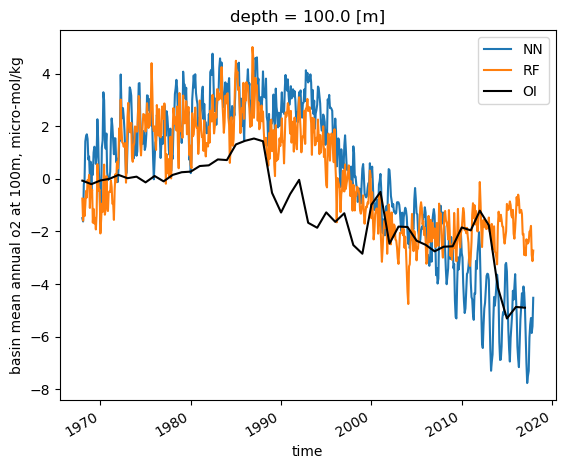

In [50]:
o2anom1.mean('lon').mean('lat').sel(time=slice('1968-01','2017-12')).plot(label='NN')
o2anom2.mean('lon').mean('lat').sel(time=slice('1968-01','2017-12')).plot(label='RF')
o2OI.mean('lon').mean('lat').sel(time=slice('1968-01','2017-12')).plot(label='OI',color='k')
plt.legend()
plt.xlabel('time')
plt.ylabel('basin mean annual o2 at '+str(zlev)+'m, micro-mol/kg')
plt.show()

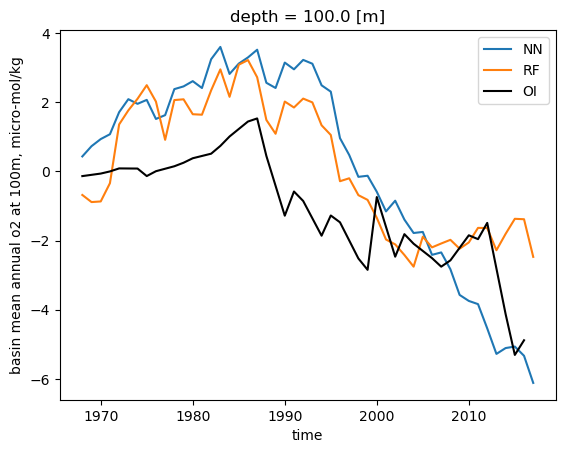

In [51]:
o2anom1.mean('lon').mean('lat').sel(time=slice('1968-01','2017-12')).groupby('time.year').mean('time').plot(label='NN')
o2anom2.mean('lon').mean('lat').sel(time=slice('1968-01','2017-12')).groupby('time.year').mean('time').plot(label='RF')
o2OI.mean('lon').mean('lat').sel(time=slice('1968-01','2017-12')).groupby('time.year').mean('time').plot(label='OI',color='k')
plt.legend()
plt.xlabel('time')
plt.ylabel('basin mean annual o2 at '+str(zlev)+'m, micro-mol/kg')
plt.show()

In [52]:
# --------------------------------
# time period needs to be checked
#---------------------------------
o2OI = ds.o2.sel(depth=zlev).sel(time=slice('1984-01','2005-01'))
Nt=np.size(o2OI.time)
t=np.arange(0,Nt,1)
t=t-np.mean(t)
a=np.nan*np.zeros((180,360))
for j in range(180):
    for i in range(360):
        if mask[j,i]==1:
            o2loc=o2OI[:,j,i]
            a[j,i]=np.mean(t*o2loc)/np.mean(t**2)
a_OI=a

In [53]:
o2NN = o2anom1.sel(time=slice('1984-01','2005-01')).groupby('time.year').mean('time')
a=np.nan*np.zeros((180,360))
for j in range(180):
    for i in range(360):
        if mask[j,i]==1:
            o2loc=o2NN[:,j,i].to_numpy()
            a[j,i]=np.mean(t*o2loc)/np.mean(t**2)
a_NN=a

In [54]:
o2RF = o2anom2.sel(time=slice('1984-01','2005-01')).groupby('time.year').mean('time')
a=np.nan*np.zeros((180,360))
for j in range(180):
    for i in range(360):
        if mask[j,i]==1:
            o2loc=o2RF[:,j,i].to_numpy()
            a[j,i]=np.mean(t*o2loc)/np.mean(t**2)
a_RF=a

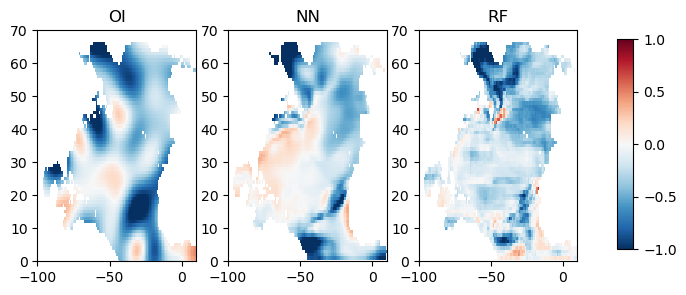

In [55]:
fig=plt.figure(figsize=(8,3))
ax=fig.subplots(1,3)
x=o2anom1.lon
y=o2anom1.lat
#
ax[0].pcolormesh(x,y,a_OI,vmin=-1,vmax=1,cmap='RdBu_r')
ax[0].set_xlim(-100,10)
ax[0].set_ylim(0,70)
ax[0].set_title('OI')
#
ax[1].pcolormesh(x,y,a_NN,vmin=-1,vmax=1,cmap='RdBu_r')
ax[1].set_xlim(-100,10)
ax[1].set_ylim(0,70)
ax[1].set_title('NN')
#
im=ax[2].pcolormesh(x,y,a_RF,vmin=-1,vmax=1,cmap='RdBu_r')
ax[2].set_xlim(-100,10)
ax[2].set_ylim(0,70)
ax[2].set_title('RF')
#
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
#
plt.show()